# Derivation of primary productivity from VIIRS

## Algorhithm of Behrenfeld and Falkowski (1997)

PP = 0.66125 * PBop * par/(par + 4.1) * Zeu *  chl * Dirr

Where:  
* PP is primary productivity  
* PBop is maximum C fixation rate within a water column, mg C mg-2 chl h-l  
* par is photosynthetically active radiation  
* Zeu is the euphotic depth (depth where irradiance is 1% of surface irradiance)  
* chl is surface chlorophyll  
* Dirr is day length  

## Required satellite datasets
* SST - https://coastwatch.pfeg.noaa.gov/erddap/griddap/nesdisVHNsstDaily.graph?sea_surface_temperature%5B(2021-01-01T12:00:00Z)%5D%5B(0.0)%5D%5B(89.75625000000001):(-89.75625000000002)%5D%5B(-179.98125000000002):(179.98124999999996)%5D    


* Chl - https://coastwatch.pfeg.noaa.gov/erddap/griddap/nesdisVHNSQchlaDaily.graph?chlor_a%5B(2021-01-01T12:00:00Z)%5D%5B(0.0)%5D%5B(89.75625):(-89.75626)%5D%5B(-179.9812):(179.9813)%5D  


* KdPAR - https://coastwatch.pfeg.noaa.gov/erddap/griddap/nesdisVHNSQkdparDaily.graph?kd_par%5B(2021-01-01T12:00:00Z)%5D%5B(0.0)%5D%5B(89.75625):(-89.75626)%5D%5B(-179.9812):(179.9813)%5D  


* PAR - from Menghua (one file for 1 Jan 2021)

## Load Python modules
Code was written using Python 3.7

In [21]:
import numpy as np
import netCDF4
import pandas as pd
import os
import xarray as xr
import numpy.ma as ma
from datetime import datetime
import subprocess
import warnings

warnings.filterwarnings("ignore")

# plotting modules
%matplotlib inline
import matplotlib.pyplot as plt
import cmocean.cm as cmo
import cartopy
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from pandas.plotting import register_matplotlib_converters
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Polygon
%matplotlib inline

## Load data

In [33]:
# nc file with all satellite data included
with netCDF4.Dataset('all_data.nc', 'a') as cw_nc:
    # Load data into variables
    par = cw_nc['par'][0,0,:,:]  # PAR
    T = cw_nc['sea_surface_temperature'][0,0,:,:]  # SST
    kd = cw_nc['kd_par'][0,0,:,:]  # KdPAR
    chl = cw_nc['chlor_a'][0,0,:,:]  # Chl
    lats_4k = cw_nc['latitude'][:]
    lons_4k = cw_nc['longitude'][:]

# change NaN fill value to -999.0
ma.set_fill_value(par, -999.0)

## Optimum photosynthetic rate
The optimum photosynthetic rate (PBop) was derived from SST using the seventh order polynomial of Behrenfeld and Falkowski (1997).  
`PBop = -3.27E-8*T^7 + 3.4132E-6*T^6 - 1.348E-4*T^5 + 2.462E-3*T^4 - 0.0205*T^3 + 0.0617*T^2 + 0.2749*T + 1.2956`

In [34]:
PBop = -3.27E-8*T**7 + 3.4132E-6*T**6 \
       - 1.348E-4*T**5 + 2.462E-3*T**4 \
       - 0.0205*T**3 + 0.0617*T**2 \
       + 0.2749*T + 1.2956

Range of photosynthetic rate values from the polynomial

In [35]:
print(PBop.min(), 'to', PBop.max(), ': mg C mg-2 Chl hr-1')

0.5568191 to 6.6268 : mg C mg-2 Chl hr-1


## Euphotic zone depth (Zeu)
Calculated from attenuation coefficient for PAR.  
Invert this equation:  
`Ez = Eo e^(-Kd*Z)`  
To:  
`-ln(Ez/Eo)/Kd = Z`

Where:  
* Eo is PAR at the surface  
* Ez is PAR at depth Z  
* Kd is the attenuation coefficient for PAR (KdPAR)  

Set Ez/Eo equal to 0.01 (1% of Eo) to and use satellite KdPAR calculate Zeu

In [36]:
Zeu = -np.log(0.01)/kd # np.log is the natural log
Zeu = ma.masked_invalid(Zeu)
print('Range in global Zeu (m)', Zeu.min(), 'to',Zeu.max())


Range in global Zeu (m) 0.7679123 to 460.51703


## Daylength
### The following function calculates day length
Inputs are the day of the year and the latitude vector for the data

In [37]:
def daylength(dayOfYear, lat):
    """Computes the length of the day (the time between sunrise and
    sunset) given the day of the year and latitude of the location.
    Function uses the Brock model for the computations.
    For more information see, for example,
    Forsythe et al., "A model comparison for daylength as a
    function of latitude and day of year", Ecological Modelling,
    1995.
    
    Modified (vectorize) from:
    https://gist.github.com/anttilipp/ed3ab35258c7636d87de6499475301ce
    
    Parameters
    ----------
    dayOfYear : int
        The day of the year. 1 corresponds to 1st of January
        and 365 to 31st December (on a non-leap year).
    lat : float
        Latitude of the location in degrees. Positive values
        for north and negative for south.
    Returns
    -------
    d : float
        Daylength in hours.
    """
    latInRad = np.deg2rad(lat)
    declinationOfEarth = 23.45*np.sin(np.deg2rad(360.0*(283.0+dayOfYear)/365.0))
    #print(declinationOfEarth)
    mask = -np.tan(latInRad) * np.tan(np.deg2rad(declinationOfEarth))
    
    hourAngle = np.rad2deg(np.arccos(-np.tan(latInRad) * np.tan(np.deg2rad(declinationOfEarth))))
    day_len = 2.0*hourAngle/15.0
    day_len[mask <= -1.0] = 24
    day_len[mask >= 1.0] = 0
    
    return day_len


### Calulate the daylength at each latitude

In [38]:
# Generate daylength vector
dl = daylength(1, lats_4k)

# create 2D array of daylength results
Dirr = np.tile(dl, (chl.shape[1], 1))
Dirr = np.transpose(Dirr)

print('Daylength ranges from:', Dirr.min(), Dirr.max())

Daylength ranges from: 0.0 24.0


Plot daylength in hours vs. latitude

Text(0.5, 1.0, 'Daylength with Latitude')

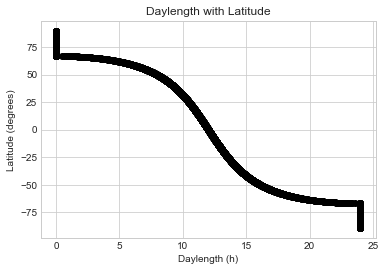

In [39]:
plt.plot(dl, lats_4k, 'o', color='black')
plt.style.use('seaborn-whitegrid')
plt.xlabel("Daylength (h)")
plt.ylabel("Latitude (degrees)")
plt.title("Daylength with Latitude")

## Primary productivity

Apply the data to the primary productivity equation

In [40]:
PP = 0.66125 * PBop * par/(par + 4.1) * Zeu *  chl * Dirr

#PP = 0.66125 X PBop * PAR/(PAR + 431) * Zeu * CHLsat * day_len_by_lat


### Map the primary productivity

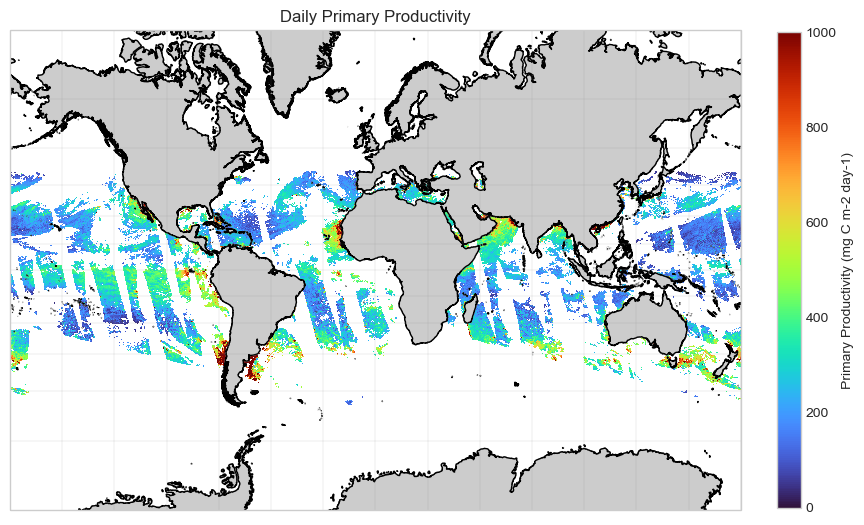

In [41]:
# define projections for use

# have to use mercator to use gridlines (this might be changing now)
merc = cartopy.crs.Mercator(central_longitude=lons_4k.mean())
pc = cartopy.crs.PlateCarree()
mill = cartopy.crs.Miller(central_longitude=lons_4k.mean())
e4 = cartopy.crs.LambertCylindrical()


# example of multiple levels of land resolution data. There are shortcuts built into cartopy too.
land_10m = cartopy.feature.NaturalEarthFeature('physical', 'land', '10m',
                                        edgecolor='face')
land_50m = cartopy.feature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face')
land_110m = cartopy.feature.NaturalEarthFeature('physical', 'land', '110m',
                                        edgecolor='face')


fig = plt.figure(figsize=(9.7, 7.7), dpi=100)
#fig = plt.figure(figsize=(4.7, 3.7), dpi=100)
ax = fig.add_axes([0.06, 0.01, 0.93, 0.95], projection=merc)
#ax.set_extent([-180, 180, -90, 90], pc) 
gl = ax.gridlines(linewidth=0.2, color='gray', alpha=0.5, linestyle='-', draw_labels=True)
gl.xlocator = mticker.FixedLocator(np.linspace(-180,180,15))
gl.ylocator = mticker.FixedLocator(np.linspace(-90,90,15))
# the following two make the labels look like lat/lon format
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.top_labels = False  # turn off labels where you don't want them
gl.right_labels = False
gl.bottom_labels = False

ax.add_feature(land_10m, facecolor='0.8')
ax.coastlines(resolution='10m')  # coastline resolution options are '110m', '50m', '10m'

# transform projection (here: pc) has to match the x, y coordinates given (here: lons_4k, lats_4k)
#cs = ax.pcolormesh(lons_4k, lats_4k, np.log10(PP), cmap=cmo.haline, transform=mill, vmin=1, vmax=3)
cs = ax.pcolormesh(lons_4k, lats_4k, PP, cmap='turbo', transform=mill, vmin=0, vmax=1000)

plt.xlabel('Longitude', labelpad = 20)
plt.ylabel('Latitude', labelpad = 40)

cbar = plt.colorbar(cs, shrink=0.65, pad=0.04)
cbar.set_label('Primary Productivity (mg C m-2 day-1)')
plt.title("Daily Primary Productivity")
plt.show()

### Add primary productivity data to the source data file

In [42]:
with netCDF4.Dataset('all_data.nc', 'a') as cw_nc:
    mypp = cw_nc.createVariable('primary_productivity', 'f8', 
                                ('time', 'altitude', 'latitude', 'longitude',), 
                                 fill_value=-999.0
                                )
    mypp[0,0,:,:] = PP[:,:]
    mypp.units = 'mg C m-2 day-1'
    mypp.colorBarMaximum = 2000.0
    mypp.colorBarMinimum = 0.0
    mypp.coordsys = "geographic"
    mypp.coverage_content_type = "physicalMeasurement"
    mypp.ioos_category = "Ocean Color"
    mypp.long_name = "Primary Productivity"
    mypp.missing_value = -999.0


## Appendices: Code for generating the source data file (all_data.nc)

### Appendix A: Pull needed data from ERDDAP

#### Create a function to build erddap URLs
This function will need to be updated to pull the PAR data when available

In [23]:
import urllib3
import certifi
def download_erddap(file_out, dataRequestUrl):
    """Download from ERDDAP needed data for primary productivity
    
    Usage: download_erddap(file_out, dataRequestUrl)
        file_out -> file name given to downloaded date
        dataRequestUrl -> ERDDAP data request URL for a netCDF file
        
    Output: netCDF file
    
    Returns: success or fail text
    
    """
    # file_out is the file name given to downloaded date
    # dataRequestUrl is the ERDDAP data request URL
    try: 
        http = urllib3.PoolManager(cert_reqs='CERT_REQUIRED', 
                                                   ca_certs=certifi.where()
                                                    )
    except:
        http = urllib3.PoolManager(cert_reqs='CERT_NONE')

    r = http.request('GET', dataRequestUrl, preload_content=False)

    # Open the file and write the data to it
    try:
        with open(file_out, 'wb') as out:
            while True:
                data = r.read(1024*1024)
                if not data:
                    break
                out.write(data)
        r.release_conn()
        tx = 'success'
    except:
        print('fail', file_out)
        tx = 'fail'
    
    return tx

#### Date of interest
For operational processing this will be automated

In [24]:
myDate = datetime(2021, 1, 1, 12, 0, 0)

#### Build the ERDDAP data query URLs
Supply the following:
* A list of ERDDAP dataset IDs  
* A corresponding list of the variable of interest from each dataset
* The ERDDAP base URL
* The URL parts for altitude, latitude, and longitude


In [26]:
# variable parts of the URL      
erd_id = ['nesdisVHNsstDaily', 'nesdisVHNSQchlaDaily', 'nesdisVHNSQkdparDaily']
erd_var = ['sea_surface_temperature', 'chlor_a', 'kd_par']

# static parts of the URL           
base_url = 'https://coastwatch.pfeg.noaa.gov'
altitude = '[(0.0)]'
latlon = '[(89.75625):(-89.75626)][(-179.9812):(179.9813)]'        
url_date = ''.join(['[(', myDate.isoformat() + 'Z', ')]'])  # create date in ERDDAP format

for i in range(0, len(erd_id)):
    req = ''.join([erd_id[i], '.nc?', erd_var[i], url_date, altitude, latlon])
    
    url = '/'.join([base_url, 'erddap', 'griddap', req])
    print(url)
    
    if i==0:
        # first time through create the file to add other data to
        #out_file = primprod, viirs_v1.nc
        download_erddap('all_data.nc', url)
    else:
        # after download append thes data to 
        download_erddap('temp.nc', url)
        myCmd = 'ncks -h -A temp.nc all_data.nc'
        os.system(myCmd)
        
print('The AllData File Created')


https://coastwatch.pfeg.noaa.gov/erddap/griddap/nesdisVHNsstDaily.nc?sea_surface_temperature[(2021-01-01T12:00:00Z)][(0.0)][(89.75625):(-89.75626)][(-179.9812):(179.9813)]
https://coastwatch.pfeg.noaa.gov/erddap/griddap/nesdisVHNSQchlaDaily.nc?chlor_a[(2021-01-01T12:00:00Z)][(0.0)][(89.75625):(-89.75626)][(-179.9812):(179.9813)]
https://coastwatch.pfeg.noaa.gov/erddap/griddap/nesdisVHNSQkdparDaily.nc?kd_par[(2021-01-01T12:00:00Z)][(0.0)][(89.75625):(-89.75626)][(-179.9812):(179.9813)]
All Data File Created


### Appendix B: Regrid 9k PAR data and add to the All Data netCDF file
Only needed for this example

#### Open 9km PAR file in xarray

In [28]:
ds = xr.open_dataset("V2021001_SCI_WW00_par 3.nc")

#### Get 4k lat and long vectors

In [29]:
with netCDF4.Dataset('all_data.nc', 'a') as cw_nc:
    # Load data into variables
    lats_4k = cw_nc['latitude'][:]
    lons_4k = cw_nc['longitude'][:]


#### Grid the data to the 4k grid

In [30]:
ds_interp = ds.interp(lat=lats_4k, lon=lons_4k)

#### Plot regridded PAR

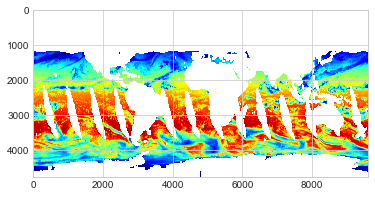

In [31]:
plt.imshow(ds_interp.par, cmap ='jet')

#### Add PAR to All Data file

In [32]:
with netCDF4.Dataset('all_data.nc', 'a') as cw_nc:
    mypar = cw_nc.createVariable('par', 'f8', 
                                 ('time', 'altitude', 'latitude', 'longitude',), 
                                 fill_value=-9999.0    
                                )
    mypar[0,0,:,:] = ma.masked_invalid(ds_interp.par)[:,:]
    mypar.units = 'mol m^-2 day^-1'
    mypar.colorBarMaximum = 0.0
    mypar.colorBarMinimum = 80.0
    mypar.coordsys = "geographic"
    mypar.coverage_content_type = "physicalMeasurement"
    mypar.ioos_category = "Ocean Color"
    mypar.long_name = "Photosynthetically Active Radiation"
    mypar.missing_value = -9999.0
    mypar.standard_name = "surface_downwelling_photosynthetic_photon_flux_in_air"


## Done